In [1]:
import torch
import sys
import scanpy as sc
import os
sys.path.append(os.path.abspath("FRLC"))
import FRLC
import FRLC_multimarginal
import importlib
import HiddenMarkovOT
import util_LR
from util_LR import convert_adata


In [2]:
'''
idxs = [1, 2, 3, 4]
timepoints_across_datasets = []
replicates_across_datasets = []

for i in idxs:
    
    filehandle_ME = f'/scratch/gpfs/ph3641/hm_ot/adata_JAX_dataset_{i}.h5ad'
    
    sys.path.insert(0, filehandle_ME)
    adata = sc.read_h5ad(filehandle_ME, backed="r")
    
    # Extract unique timepoints
    timepoints = list( adata.obs['day'].unique() )
    
    if 'P0' in timepoints:
        # Not one of the E_XYZ formatted stages, so removing
        timepoints.remove('P0')
    
    # Sort timepoints by the numeric value after removing the "E" prefix
    timepoints = sorted(timepoints, key=lambda tp: float(tp.replace("E", "")))
    
    # Extract unique replicates
    replicates = adata.obs['embryo_id'].unique()  # Biological replicates
    batches = adata.obs['experimental_batch'].unique()  # Technical batches
    
    replicates = []
    
    for tp in timepoints:
        replicates.append( adata[adata.obs['day'] == tp].obs['embryo_id'].unique()[0] )

    # Display results
    print("Timepoints:", timepoints)
    print("Biological Replicates (Embryo IDs):", replicates)
    print("Technical Batches:", batches)
    
    timepoints_across_datasets.append(timepoints)
    replicates_across_datasets.append(replicates)
    
    del adata
'''

'\ntimepoints_across_datasets = []\nreplicates_across_datasets = []\n\nfor i in idxs:\n    \n    filehandle_ME = f\'/scratch/gpfs/ph3641/hm_ot/adata_JAX_dataset_{i}.h5ad\'\n    \n    sys.path.insert(0, filehandle_ME)\n    adata = sc.read_h5ad(filehandle_ME, backed="r")\n    \n    # Extract unique timepoints\n    timepoints = list( adata.obs[\'day\'].unique() )\n    \n    if \'P0\' in timepoints:\n        # Not one of the E_XYZ formatted stages, so removing\n        timepoints.remove(\'P0\')\n    \n    # Sort timepoints by the numeric value after removing the "E" prefix\n    timepoints = sorted(timepoints, key=lambda tp: float(tp.replace("E", "")))\n    \n    # Extract unique replicates\n    replicates = adata.obs[\'embryo_id\'].unique()  # Biological replicates\n    batches = adata.obs[\'experimental_batch\'].unique()  # Technical batches\n    \n    replicates = []\n    \n    for tp in timepoints:\n        replicates.append( adata[adata.obs[\'day\'] == tp].obs[\'embryo_id\'].unique()[0

In [3]:
"""
Timepoints, indexed by AnnData index
"""

timepoints_across_datasets =  [['E8.5', 'E8.75', 'E9.0', 'E9.25', 'E9.5', 'E9.75', 'E10.0', 'E10.25', 'E10.5', 'E10.75'], \
                               ['E11.0', 'E11.25', 'E11.5', 'E11.75', 'E12.0', 'E12.25', 'E12.5', 'E12.75', 'E13.0', 'E13.25', 'E13.5', 'E13.75'], \
                               ['E14.0', 'E14.25', 'E14.333', 'E14.75', 'E15.0', 'E15.25', 'E15.5', 'E15.75', 'E16.0', 'E16.25', 'E16.5', 'E16.75'], \
                               ['E17.0', 'E17.25', 'E17.5', 'E17.75', 'E18.0', 'E18.25', 'E18.5', 'E18.75']]


In [4]:
import pandas as pd
import objective_grad
import clustering
import HiddenMarkovOT
import plotting
import pickle
import numpy as np
import jax


print(jax.devices())

# Filehandle for final differentiation map outputs
diffmap_dir = "/scratch/gpfs/ph3641/hm_ot/ME_supervised_diffmap_moscot_allrep/"
os.makedirs(diffmap_dir, exist_ok=True)

# Cell-type labels for all timepoints + replicates
df_cell = pd.read_csv("/scratch/gpfs/ph3641/hm_ot/df_cell.csv")
df_cell = df_cell.set_index("cell_id")



[CudaDevice(id=0)]


Aligning timepoint E8.5 to E8.75
Aligning timepoint E8.75 to E9.0
Aligning timepoint E9.0 to E9.25
Aligning timepoint E9.25 to E9.5
Adata1: 
View of AnnData object with n_obs × n_vars = 276424 × 24552
    obs: 'keep', 'day', 'embryo_id', 'experimental_batch', 'celltype_update'
    var: 'gene_id', 'gene_type', 'gene_short_name', 'chr'
Adata2: 
View of AnnData object with n_obs × n_vars = 336999 × 24552
    obs: 'keep', 'day', 'embryo_id', 'experimental_batch', 'celltype_update'
    var: 'gene_id', 'gene_type', 'gene_short_name', 'chr'
Rank 1: 78 to Rank 2: 82
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
rank: 78
Running moscot
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(276424, 336999)].                              
WARNING  Solver did not converge                               

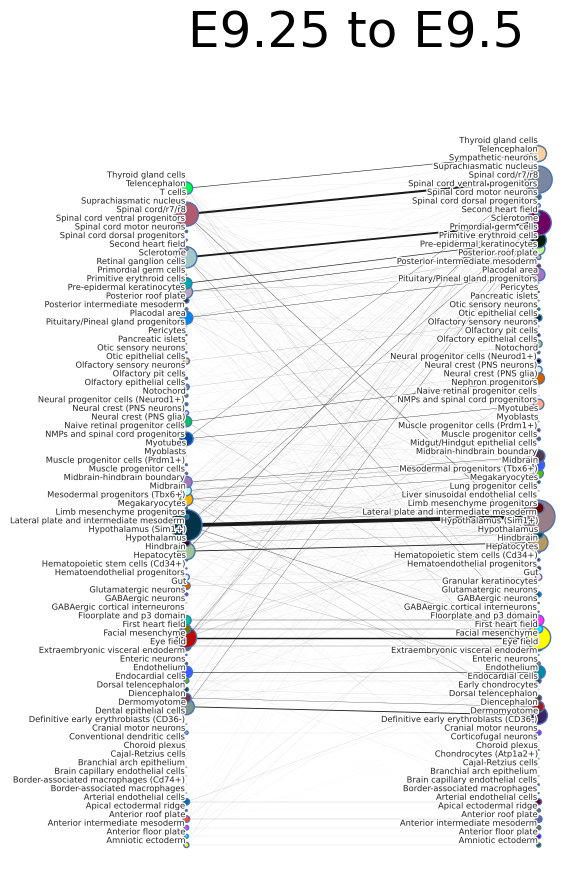

Aligning timepoint E9.5 to E9.75



KeyboardInterrupt



In [5]:
import re
import moscot as mt
import moscot.plotting as mpl
import scanpy as sc

from moscot.problems.time import TemporalProblem

import time

for i in range(len(timepoints_across_datasets)):
    
    """
    Loading file / AnnData
    """
    filehandle_ME = f'/scratch/gpfs/ph3641/hm_ot/adata_JAX_dataset_{idxs[i]}.h5ad'
    sys.path.insert(0, filehandle_ME)
    adata = sc.read_h5ad(filehandle_ME, backed="r")
    
    timepoints = timepoints_across_datasets[i]
    
    for tp in range(len(timepoints)):
        """
        Iterating across all timepoint pairs, stitching separate AnnDatas together when necessary.
        """
        if (tp+1) < len(timepoints):
            
            # Aligning two timepoints within a dataset.
            t1 = timepoints[tp]
            t2 = timepoints[tp+1]
            
            print(f'Aligning timepoint {t1} to {t2}')
            
            # Generate a pairwise subset of the dataset
            subset_adata = adata[
                    (adata.obs['day'].isin(timepoints[tp:tp+2])) 
                ] #.copy(filename='/scratch/gpfs/ph3641/hm_ot/adata_subset.h5ad')
        
        elif ( i+1 < len(idxs)-1 ):
            
            timepoints2 = timepoints_across_datasets[i+1]
            
            # Stitch timepoints between datasets until no remaining AnnData objects left!
            t1 = timepoints[tp]
            t2 = timepoints2[0]
            
            print(f'Aligning timepoint {t1} to {t2}')
            
            filehandle_ME2 = f'/scratch/gpfs/ph3641/hm_ot/adata_JAX_dataset_{idxs[i]+1}.h5ad'
            sys.path.insert(0, filehandle_ME2)
            
            # Being memory-efficient; save last timepoint into its own object, delete, and load next.
            adata = adata[
                    ( adata.obs['day'] == t1 ) 
                ].to_memory() #.copy(filename='/scratch/gpfs/ph3641/hm_ot/adata_fin.h5ad')
            
            adata2 = sc.read_h5ad(filehandle_ME2, backed="r")

            print(f'time2: {t2}')
            
            adata2 = adata2[
                    (adata2.obs['day'] == t2 ) 
                ].to_memory() #.copy(filename='/scratch/gpfs/ph3641/hm_ot/adata2_init.h5ad')
            
            # Concatenate the two AnnData objects
            subset_adata = adata.concatenate(
                adata2,
                index_unique=None
            )
        
        if not os.path.isfile( os.path.join(diffmap_dir, t1 + "_" + t2 + "_T.npy") ):
            
            """
            Now, (1) integrate cell-type labels and (2) perform HM-OT on the one-hot encoded labels.
            """
            subset_adata = subset_adata.to_memory()
            
            subset_adata.obs = subset_adata.obs.set_index("cell_id")
            subset_adata.obs = subset_adata.obs.join(df_cell[['celltype_update']], how="left")
    
            print(f'Adata1: ')
            print(subset_adata[subset_adata.obs['day'] == t1])
            print(f'Adata2: ')
            print(subset_adata[subset_adata.obs['day'] == t2])
            
            '''
            print('-----Starting PCA!-----')
            
            sc.pp.normalize_total(subset_adata, target_sum=1e4)  # Normalize per cell
            sc.pp.log1p(subset_adata)
            sc.pp.pca(subset_adata, n_comps=30)
            print('-----PCA done!-----')
            '''
            
            tps = [t1, t2]
    
            """ Compute ranks """
            rank1 = subset_adata[subset_adata.obs['day'] == t1].obs['celltype_update'].nunique()
            rank2 = subset_adata[subset_adata.obs['day'] == t2].obs['celltype_update'].nunique()
            print(f'Rank 1: {rank1} to Rank 2: {rank2}')
    
            """
            Set distance matrix rank; if number of cell-types less than 100 then set to 100,
                otherwise default to smallest number of cell-types
            """
            
            Q1, L1 = util_LR._compute_Q(subset_adata[subset_adata.obs['day'] == t1], 'celltype_update')
            Q2, L2 = util_LR._compute_Q(subset_adata[subset_adata.obs['day'] == t2], 'celltype_update')
            
            subset_adata.obs['day'] = subset_adata.obs['day'].str.extract(r'(\d+(?:\.\d+)?)').astype(float)
            subset_adata.obs['day'] = pd.Categorical(subset_adata.obs['day'], ordered=True)
            
            tp = TemporalProblem(subset_adata)
            
            tp = tp.prepare(
                        time_key="day"
                        )
            
            r = min([rank1, rank2])
            print(f'rank: {r}')
    
            print('Running moscot')
            s = time.time()
            # For equivalent comparison, using same relaxation of marginals
            tp = tp.solve(epsilon=1e-3,
                          tau_a=1.0,
                          tau_b=1.0,
                          scale_cost="mean",
                          batch_size=8192,
                          device = 'gpu') # rank=r, 
            
            subset_adata.obs["celltype_update"] = subset_adata.obs["celltype_update"].astype("category")
            subset_adata.obs['celltype_update']
            
            t1_numeric, t2_numeric =  float(re.search(r"[-+]?\d*\.\d+|\d+", t1).group()), float(re.search(r"[-+]?\d*\.\d+|\d+", t2).group())
            
            tp.cell_transition(source = t1_numeric,
                   target = t2_numeric,
                    source_groups="celltype_update",
                    target_groups="celltype_update",
                    forward=True,
                    key_added="cell_transition"
                    )
            
            # Extract moscot transition matrix
            tm = subset_adata.uns['moscot_results']['cell_transition']["cell_transition"]['transition_matrix']
            e = time.time()
            print(f'Time to compute transition matrix using moscot: { (e-s) }, dataset size: { subset_adata.shape[0] }')
            
            # Order the TM by the label lists
            tm_ordered = tm.loc[L1, L2]
            
            T = tm_ordered.to_numpy()
            T = np.diag(np.sum(Q1, axis=0)) @ T
            
            """
            Can verify this T satisfies correct marginals.
            print(np.sum(T, axis = 1))
            print(np.sum(T, axis = 0))
            print(np.sum(Q1, axis=0))
            print(np.sum(Q2, axis=0))
            """
            
            Ts_ann = [T]
            
            Qs_ann = [Q1, Q2]
            labels = [L1, L2]
            
            plotting.diffmap_from_QT(Qs_ann, Ts_ann, labels, dsf=0.01, fontsize=6, linethick_factor=20, \
                                     title= t1 + " to " + t2,
                                    save_name = os.path.join("/scratch/gpfs/ph3641/hm_ot/ME_supervised_figs/", t1+"_"+t2+".png" ))
            
            # Save Q matrices and T matrices as before
            np.save(os.path.join(diffmap_dir, t1 + "_Q.npy"), Qs_ann[0])
            np.save(os.path.join(diffmap_dir, t2 + "_Q.npy"), Qs_ann[1])
            np.save(os.path.join(diffmap_dir, t1 + "_" + t2 + "_T.npy"), Ts_ann[0])
            
            # Save the cell-type labels for each timepoint using write binary mode
            with open(os.path.join(diffmap_dir, t1 + '_types.pkl'), 'wb') as f:
                pickle.dump(labels[0], f)
            
            with open(os.path.join(diffmap_dir, t2 + '_types.pkl'), 'wb') as f:
                pickle.dump(labels[1], f)


In [ ]:
times_sizes = {
    'E8.5_8.75': (311.581, 199850),
    'E8.75_9.0': (249.244, 164302),
    'E9.0_9.25': (1206.838, 394473),
    'E9.25_9.5': (3224.665, 613423),
    'E9.5_9.75': (),
    'E9.75_10.0': (),
    'E10.0_10.25': (),
    'E10.25_10.5': (),
    'E10.5_10.75': ()
}

In [ ]:
import os
import numpy as np
import pickle
import importlib
importlib.reload(plotting)


timepoints = ['E8.5', 'E8.75', 'E9.0', 'E9.25', 'E9.5', 'E9.75', 'E10.0', 'E10.25', 'E10.5', 'E10.75',
              'E11.0', 'E11.25', 'E11.5', 'E11.75', 'E12.0', 'E12.25', 'E12.5', 'E12.75',
             'E13.0', 'E13.25', 'E13.5', 'E13.75', 'E14.0']

timepoints =  ['E8.5', 'E8.75', 'E9.0', 'E9.25', 'E9.5', 'E9.75', 'E10.0']

_Qs = []
_Ts = []
_labels = []

for i in range(len(timepoints) - 1):
    
    t1 = timepoints[i]
    t2 = timepoints[i + 1]

    print(f'loading {t1} to {t2}')
    
    # Load Q and T matrices
    Q1 = np.load(os.path.join(diffmap_dir, f"{t1}_Q.npy"))
    Q2 = np.load(os.path.join(diffmap_dir, f"{t2}_Q.npy"))
    T12 = np.load(os.path.join(diffmap_dir, f"{t1}_{t2}_T.npy"))
    
    if i == 0:
        _Qs.append(Q1)
    _Qs.append(Q2)
    _Ts.append(T12)
    
    # Load labels
    with open(os.path.join(diffmap_dir, f"{t1}_types.pkl"), 'rb') as f:
        Label_t1 = pickle.load(f)
    with open(os.path.join(diffmap_dir, f"{t2}_types.pkl"), 'rb') as f:
        Label_t2 = pickle.load(f)
    
    if i == 0:
        _labels.append(Label_t1)
    _labels.append(Label_t2)

# Plot the full alignment
plotting.diffmap_from_QT(
    _Qs, _Ts, _labels,
    dsf=0.01,
    fontsize=5,
    linethick_factor=55,
    title=f"Alignment from {timepoints[0]} to {timepoints[-1]}",
    save_name=os.path.join("/scratch/gpfs/ph3641/hm_ot/ME_supervised_figs/all.png")
)